# <u> Chapter 2b: Fundamentals of Image Data Reduction and Flux Calibration

<div class="alert alert-block alert-info">
    
### This Notebook will lead you through exercises to learn the basics of image data reduction and flux calibration.

### In this notebook, you will:

- learn the meaning of bias frames and flat fields, and how these are used to reduce imaging data
- learn how to flux calibrate an image in order to measure a source's absolute or apparent flux and magnitude
- understand the relative importance of photometric and systematic errors, and under what conditions these sources of error dominate

### If you have time:
- Produce a relative flux-calibrated light curve of a transit and determine what the reduction in scatter is compared to the uncalibrated light curve

### What's next:
After you have completed this notebook:

- apply your knowledge in Coursework A
- you will move on to use available photometry to learn statistical methods and tools to fit a light curve
    
### Table of contents:

- [Background](#sec:bg)
- [1. Image Data reduction - step by step](#sec:imred)
    - [1.1 Bias subtraction](#sec:bias)
    - [1.2 Flat fielding](#sec:flat)
- [2. Photometry](#sec:phot)
- [3. Flux calibration](#sec:flux)
    - [3.1 Determining the zeropoint](#ssec:zp)
- [4. Systematic uncertainties and relative photometry](#sec:relphot)
    - [4.1 Absolute versus relative flux](#ssec:absVsrel)
- [Summary](#sec:summary)

<a id="sec:bg"></a>
## Background - CCD detectors in Astronomy

For your research project, you will be working with imaging data. In modern astronomy ultraviolet, optical and X-ray detectors are charge-coupled devices (CCDs), which are effectively arrays of tiny detectors (pixels), where each pixel converts incoming photons into an electric signal. How effective a CCD is at converting incident photons into charge is referred to as the quantum efficiency (QE), which is heavily dependent on wavelength. It is now possible to have QEs of 70-90% at optical wavelengths (compared to 1-2% for the eye). An example of a QE curve is shown below, which shows high efficiency in the optical regime, peaking at ~700nm, although this will vary depending on the CCD design.

<img src="misc/detector-QEs-FB.gif" style="width: 500px;"/>

### Bias images
To avoid there being negative counts due to fluctuations in the read out noise, a constant voltage is applied, referred to as the bias level. Although in theory this should appear as a constant value added to an astronomical image, in practice pixel-to-pixel variations are also present due to read-out noise. In order to remove the contribution to an image from the bias, we use a *bias frame*, which is a CCD image with an exposure time of zero seconds and shutter closed, so the CCD is simply read out. This bias frame can then be subtracted from the raw image. In practice, several bias frames are averaged together to produce a *master bias frame*, which reduces the impact of readout noise and gives a more accurate estimate of the bias level.

### Flat field
The detector and optics of an instrument will always have imperfections that produce variations in sensitivity across the focal plane. To optimise the accuracy of our astronomical images, we therefore need to correct for these variations across the image. This is done using a flat-field, which is a normally exposed image with the entire field of view of the image lit as uniformly as possible (i.e. no sources visible in the image). The main causes for image imperfections are:

&emsp;$\bullet$ imperfections in the CCD

&emsp;$\bullet$ vignetting in the optics, where the brightness of an image fades towards the edges

&emsp;$\bullet$ dust particles anywhere in the optical path

These will all affect the flat field in the same way as the astrophysical observation. The flat-field therefore provides a measure of the relative sensitivity of the detector, and dividing an astronomical observation by the (bias-subtracted) flat-field image normalises out these differences in sensitivity from the image. As in the case of the master bias frame, several frames are used to produce a *master flat frame*.

<a id="sec:imred"></a>
## 1. Image data reduction - step by step

In [1]:
### Necessary imports for this notebook

# ImageData is a supplemtary set of code used to read in raw image and calibration files
from imgdatareduction import ImageData

# numpy allows mathematical funtions to be applied to the data
import numpy as np

# pylab and matplotlib are python modules used to plot data
import pylab
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

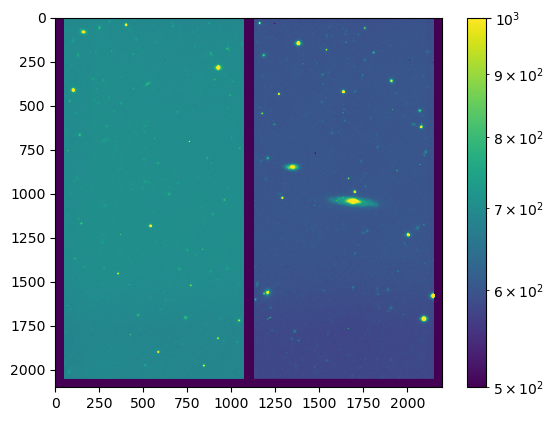

In [2]:
# First let's read in a raw image
raw = 'GROND_rband.246_0006.fits'
image = ImageData(filen=raw)

# And let's take a look at it
pylab.imshow(image.raw,norm=LogNorm(vmin=500,vmax=1000))
pylab.colorbar()

### Number of detectors in camera
Urhhhh!! That doesn't look great. The detector is made of two chips, each with their own bias level. This can be seen in the above image by the 'chip gap' between the two detectors, and by the difference in the background level. We need to get rid of the chip gap before moving forward.

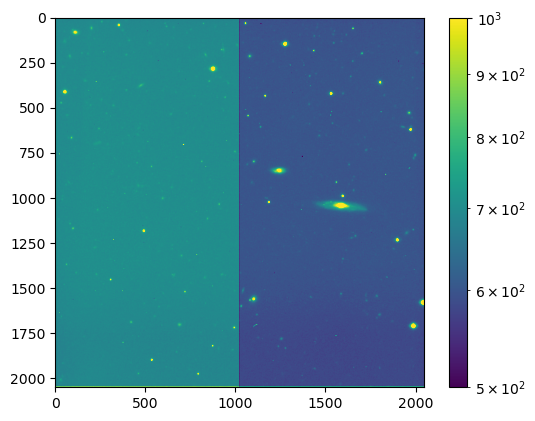

In [3]:
# Let's now take a look at the trimmed raw image
pylab.imshow(image.rawtrim,norm=LogNorm(vmin=500,vmax=1000))
pylab.colorbar()




Better, but the difference in bias levels is still clear

<a id="sec:bias"></a>
### 1.1 Bias Subtraction
We need a bias frame, taken in the same filter as the raw image, which we can then subtract from the raw image

In [4]:
# Read in bias frame
bias = 'bias_r.fits' 
image.readbias(bias)

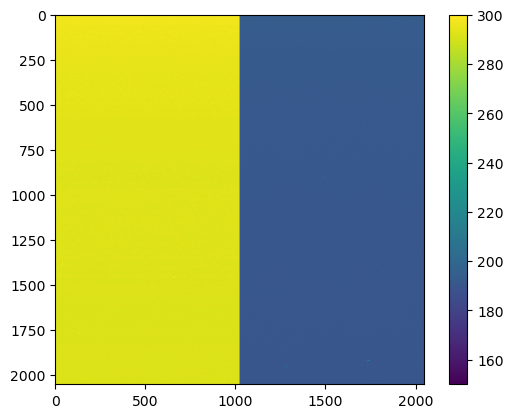

In [5]:
# Plot bias frame to see what it looks like
pylab.imshow(image.bias,vmin=150,vmax=300)
pylab.colorbar()

The difference in the bias level between the two chips can be clearly seen above

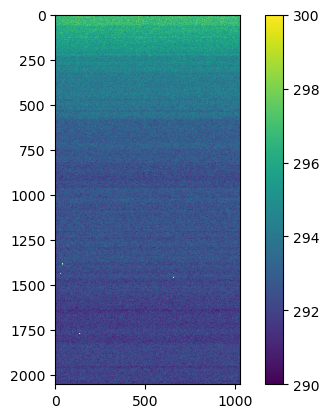

In [6]:
# Let's just look at one of the chips now, in order to see the low-level, pixel-to-pixel variation
pylab.imshow(image.bias[:,:-1023],vmin=290,vmax=300)
pylab.colorbar()

A smooth gradient can be seen along the CCD, and the variation is only at the 1-2% level

Let's take a closer look at these variations by plotting a histogram of the counts/pixel on chip 1 in the bias frame

Text(0, 0.5, 'Number of pixels')

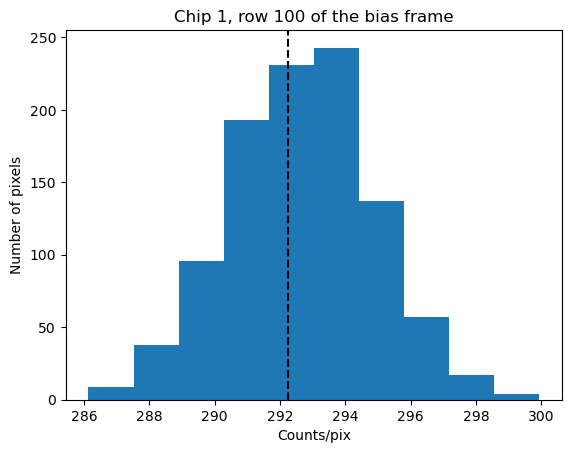

In [7]:
# First let's plot a histogram of the counts/pix along row 10000
pylab.hist(image.bias[1000:1001,:-1023].ravel())
pylab.plot([image.chip1_bl,image.chip1_bl],[0,255],ls='--',c='k')
pylab.ylim([0,255])
pylab.title('Chip 1, row 100 of the bias frame')
pylab.xlabel('Counts/pix')
pylab.ylabel('Number of pixels')

The black dashed line above represents the average counts/pixel in chip 1, and the width of the histogram provides insight on the amount of read-out noise.

<div class="alert alert-block alert-success">
    
### Your turn
    
Produce a histogram to show the variation in the bias frame along chip 2. What happens if you plot the distribution along one of the columns?
</div>

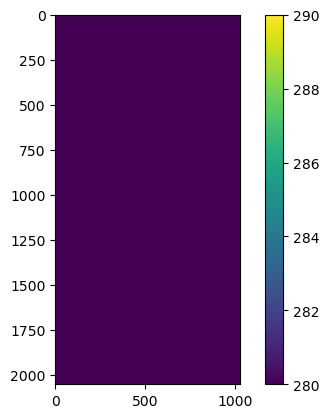

In [8]:
# Let's just look at one of the chips now, in order to see the low-level, pixel-to-pixel variation
pylab.imshow(image.bias[:,1023:],vmin=280,vmax=290)
pylab.colorbar()

Text(0, 0.5, 'Number of pixels')

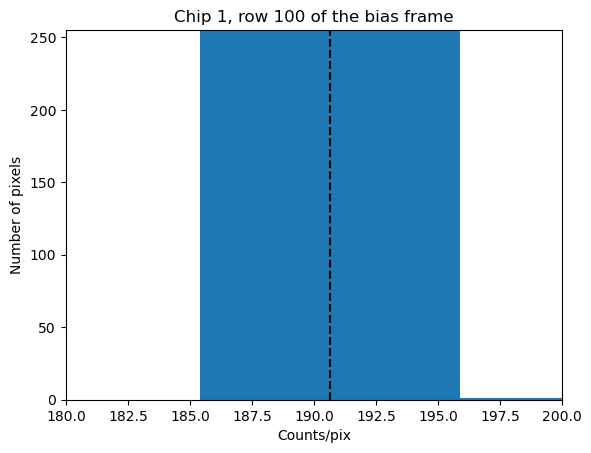

In [9]:
# First let's plot a histogram of the counts/pix along row 10000
pylab.hist(image.bias[1000:1001,1023:].ravel())
pylab.plot([image.chip2_bl,image.chip2_bl],[0,255],ls='--',c='k')
pylab.ylim([0,255])
pylab.xlim([180,200])
pylab.title('Chip 1, row 100 of the bias frame')
pylab.xlabel('Counts/pix')
pylab.ylabel('Number of pixels')

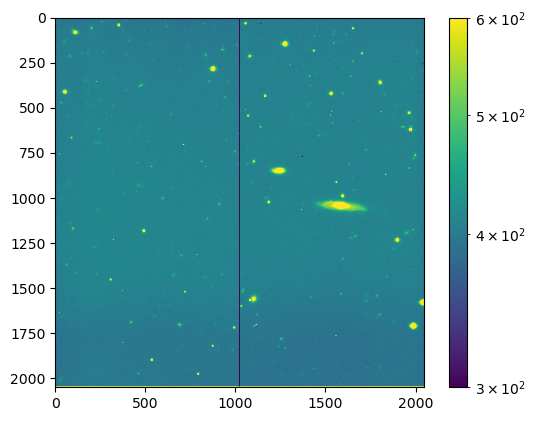

In [10]:
# We can now simply subtract the bias frame from the raw image.
image.bias_subtract()

# Let's take a look at what the bias-subtracted, raw image looks like
pylab.imshow(image.biassub,norm=LogNorm(vmin=300,vmax=600))
pylab.colorbar()

##### There is now no noticeable difference in the background level of the right and left hand side of the image above, suggesting that the bias subtraction has worked well

<a id="sec:flat"></a>
### 1.2 Flat Fielding

In [11]:
# Let's now use a flatfield to remove imperfections across the image
flat = 'flat_r.fits'
image.readflat(flat)

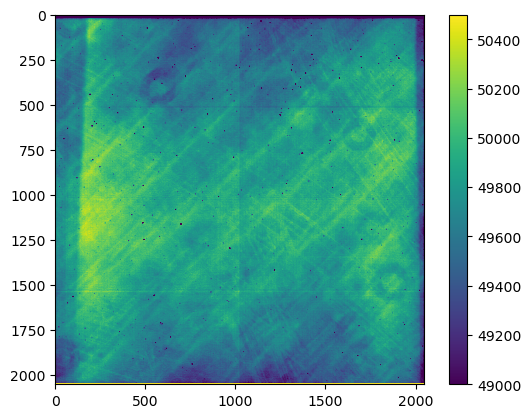

In [12]:
# This is what the flat frame looks like
pylab.imshow(image.flat,vmin=49000,vmax=50500)
pylab.colorbar()

The very large number of counts in the image is in order to increase the accuracy with which changes in sensitivity across the image can be measured.

Note that the bias frame has already been removed from the above image. The variation that remains is related to differences in sensitivity across the detector.

**Using the colour bar, can you estimate what the percentage variation is in sensitivity?**


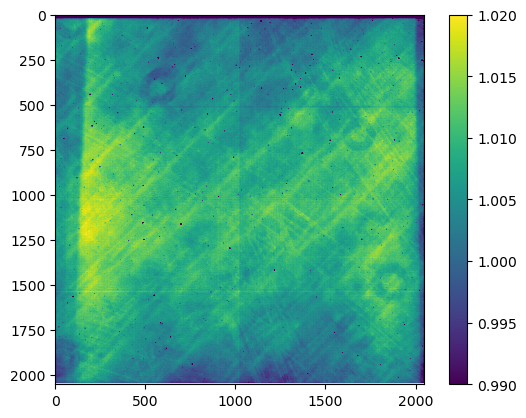

In [13]:
# Before flat-fieldig, we need to renormalise the flat-field so that the average number of counts is 1
image.flat = image.flat/np.mean(image.flat)

# Let's look at the flat-field again
pylab.imshow(image.flat,vmin=0.99,vmax=1.02)
pylab.colorbar()

The image is similar to the one above, but the number of counts are greatly reduced to all lie at around 1 cts/s.

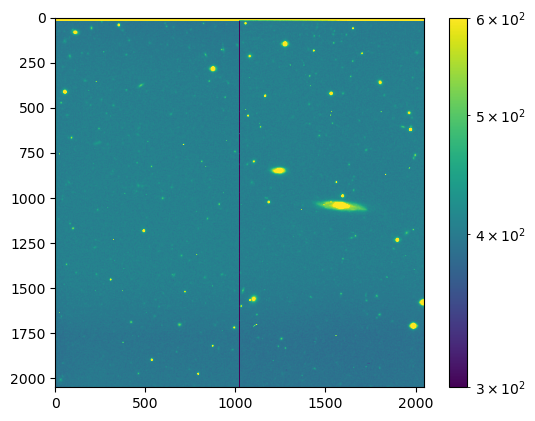

In [14]:
# Let's now flat-field our data image
image.flatfield()

# And this is what your final, bias-subtracted, flat-fielded fits file looks like
pylab.imshow(image.red,norm=LogNorm(vmin=300,vmax=600))
pylab.colorbar()

Don't forget to save the reduced image

In [15]:
image.savefits(image.red,'my_reddata')

<a id="sec:phot"></a>
## 2. Photometry
Now that we have reduced data, let's try and measure the brightness of some point sources in the images

In [16]:
# Import necessary packages to do aperture photometry
from photutils import aperture_photometry
import photutils

(<matplotlib.patches.Circle at 0x26254c160a0>,)

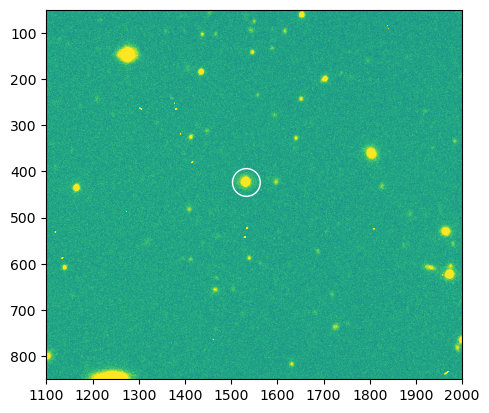

In [17]:
# First let's zoom into a part of the image
pylab.xlim(1100,2000)
pylab.ylim(850,50)
pylab.imshow(image.red,norm=LogNorm(vmin=300,vmax=500))

# And let's try and measure the flux from the point-source circled below in white
xpos=1533
ypos=424
srcrad=30
aperture1 = photutils.CircularAperture((xpos, ypos), srcrad)
aperture1.plot(ec='white')

<div class="alert alert-block alert-success">

### Your turn
    
Use your phometry tools to determine the background-subtracted flux and uncertainty of the source highlighted above

NOTE: the units in the above image are counts/pix, the exposure time of the image is 330 sec and the read out noise (RON) is 5.75 counts
</div>

In [30]:
interesting_star = aperture_photometry(image.red, aperture1)
print(interesting_star)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1  1533.0   424.0 1448378.4559709053


<div class="alert alert-block alert-success">

What happens if you measure the flux of the star on the raw or bias-subtracted only images? Do you measure a similar flux and signal-to-noise ratio?
    
</div>

<a id="sec:flux"></a>
## 3. Flux calibration
You now have a measured flux. However, as described in previous notebooks, the flux measured at the detector is dependent on properties of the detector itself (i.e. QE), the filter used (i.e. the transmission as function of wavelength), and atmospheric conditions that absorb and scatter some of the incoming light.

##### So how does the flux that you have measured correspond to the absolute brightness of the source?

We need a 'standard star' in the field for which we know the *true* brightness based on observations taken with other telescopes. We can thus use these previously acquired standard star measurements to flux calibrate our image.

(<matplotlib.patches.Circle at 0x26256927fa0>,)

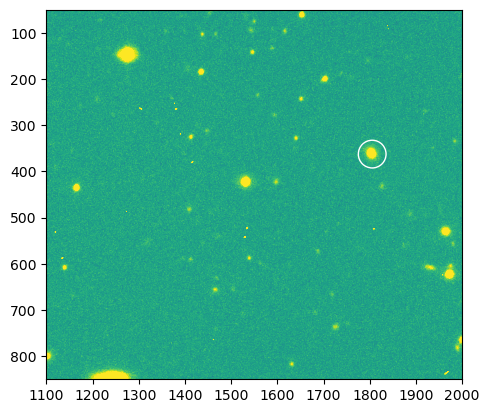

In [19]:
# Let's assume that the star shown below is a standard star, which means that we know its intrisic brightness

# Highlight standard star in data image
stdstar_xpos=1805.3
stdstar_ypos=362.6
std_aper = photutils.CircularAperture((stdstar_xpos, stdstar_ypos), srcrad)

# Show the initial image again and overplot the aperture
pylab.xlim(1100,2000)
pylab.ylim(850,50)
pylab.imshow(image.red,norm=LogNorm(vmin=300,vmax=500))
std_aper.plot(ec='white')

<div class="alert alert-block alert-success">

### Your turn
    
Measure the background-subtracted flux for the standard-star indicated above 
    
</div>

In [31]:
standard_star = aperture_photometry(image.red, std_aper)
print(standard_star)


 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1  1805.3   362.6 1276409.7486153052


<a id="ssec:zp"></a>
### 3.1 Determining the zeropoint
Let's say that we know that the true (flux calibrated) apparent r-band magnitude of the standard star shown above is 19.50 mag

We can then use your measured, background-subtracted flux for this source to determine the zeropoint of the above image. The zeropoint of an image is the magnitude that corresponds to a source with a flux of 1 cts/sec.

The magnitude of a star is related to its flux by:

     Mag = zeropoint - 2.5log(Flux)
     
**Note: the zeropoint determined above corresponds to the flux measured within a given, fixed aperture. If the source extraction aperture that you use changes, then either the zeropoint would also have to change accordingly, or you have to apply what is referred to as an 'aperture-correction'.**

<div class="alert alert-block alert-success">

### Your turn
    
Use the equation above to determine the image zeropoint
    
</div>

In [40]:
zeropoint = standard_star['aperture_sum'].value


mag = zeropoint - 2.5*np.log10(interesting_star['aperture_sum'].value)

array([-171968.7073556])

In [42]:
zeropoint_mag = 19.5 + 2.5*np.log10(zeropoint)
mag_star = zeropoint_mag -2.5*np.log10(interesting_star['aperture_sum'].value)
mag_star

array([19.36277014])

<div class="alert alert-block alert-success">

Based on the zeropoint that you determine, what is the apparent magnitude of the source of interest?
    
</div>

<a id="sec:relphot"></a>
## 4. Systematic uncertainties and relative photometry
You have now seen in this notebook and in the previous notebook on photometry that there are several sources of uncertainty that affect the accuracy with which you can measure the flux of an astronomical object. From these exercises you should thus have a better understanding of what the dominant sources of uncertainty are, and thus what should be done in principle to obtain very accurate photometry, such as is necessary to detect a transit from an exoplanet.

An important distinction in the sources of error that exist is between systematic and random uncertainties:

>$\bullet$ **Random uncertainties** are unpredictable changes in the photon flux that we measure

>$\bullet$ **Systematic uncertainties** cause a constant offset (plus or minus) in your measurements.

Read-out noise and the sky background are examples of random noise that affect each data point differently, and fundamentally set the precision of our final photometric measurement.

An example of a systematic uncertainty is the accuracy with which we know the magnitude of our standard star. If the true apparent flux of the standard star is in fact 0.03 mag brighter than the value we used in our flux calibration, each data point in our light curve would be 0.03 mag too dim. The uncertainty in the zeropoint (originating from the uncertainty in the standard star apparent magnitude) would thus cause our entire measured light curve to shift up or down, and this is thus referred to as a *systematic* uncertainty. Although the apparent magnitude of the object would be (slightly) incorrect, the shape of the light curve would be unaffected.

<a id="ssec:absVsrel"></a>
### 4.1 Absolute versus relative flux
If the science objectives rely only on the flux *evolution* of a source rather than on the *absolute* flux value, it is no longer necessary to calibrate astronomical observations against a standard star. Instead, we can use changes in the brightness of a non-standard, non-varying star in the field of view to make corrections to our photometry and obtain a light curve with accurate *relative* photometry. Non-standard here means that we do not know the star's apparent magnitude; it has not already been determined previously with other, sensitive, well-calibrated instruments.

Relative photometry can be very useful, since the fraction of stars that are 'standardised' (i.e. the apparent magnitude is well measured) in certain areas of the sky can be very small (in particular in the southern hemisphere). Astronomical observations thus frequently do not contain any standard stars within the science frame. In this case either separate observations need to be taken of a standard star, which is time consuming and requires very good weather conditions to obtain reliable results (no clouds at all; not even thin clouds), or we can derive the relative photometry.

To illustrate how relative photometry works, consider the two background-subtracted light curves below, corresponding to an exoplanet transit and to a non-varying star that have been observed simultaneously with the same instrument. Both light curves are thus obtained using the same bias-subtracted, flat-fielded images.

Text(0.5, 1.0, 'Exoplanet')

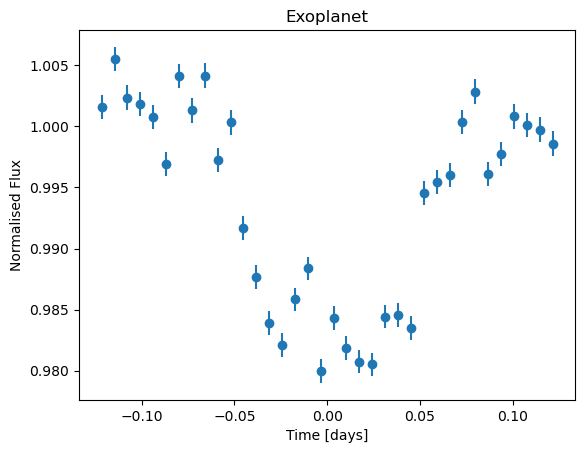

In [21]:
# Simulated transit light curve
transit_dat = np.loadtxt('Data/transit_noisy.dat')
ts_t, ts_f, ts_e = transit_dat[:,0], transit_dat[:,1], transit_dat[:,2]
pylab.errorbar(ts_t,ts_f,ts_e,ls='None',marker='o')
pylab.xlabel('Time [days]')
pylab.ylabel('Normalised Flux')
pylab.title('Exoplanet')

Text(0.5, 1.0, 'Non-varying Star')

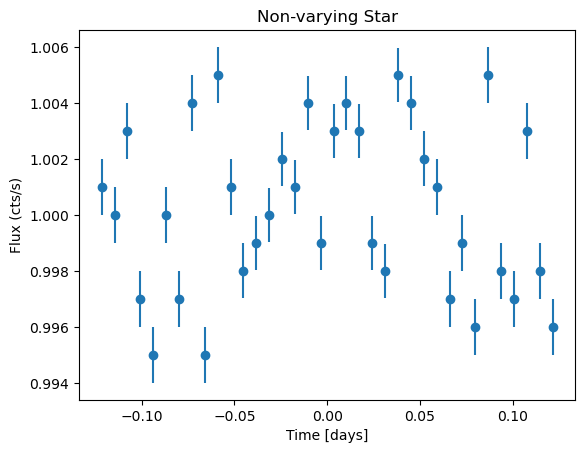

In [22]:
# Simulated non-varible star light curve
star_dat = np.loadtxt('Data/star_lc.dat')
star_t, star_f, star_e = star_dat[:,0], star_dat[:,1], star_dat[:,2]
pylab.errorbar(star_t,star_f,star_e,ls='None',marker='o')
pylab.xlabel('Time [days]')
pylab.ylabel('Flux (cts/s)')
pylab.title('Non-varying Star')

Given that we know that the star is not varying, the variation in the light curve plotted above cannot be intrinsic, and instead reflects changes in attenuation of the star's light due to evolving observing conditions.

We can correct for this variation by calculating how far each data point is from some reference value (e.g. the mean flux, or flux of the first data point), and apply this correction to our transit observation

In [23]:
# First let's measure the average flux of the star
meanflux = np.mean(star_f)
print("The star has a mean flux of %.1f cts/sec" % meanflux)

The star has a mean flux of 1.0 cts/sec


Text(0, 0.5, 'Flux (cts/s)')

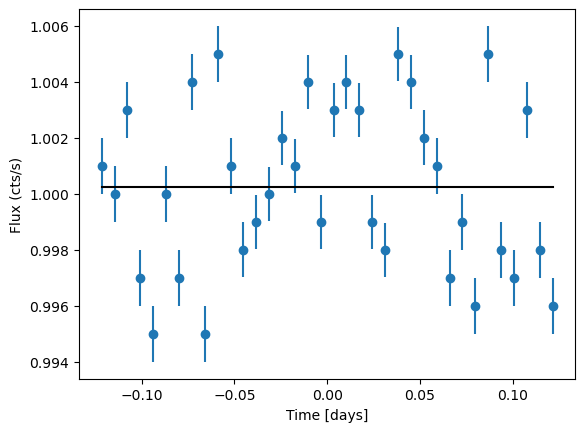

In [24]:
# Let's see how far each data point lies from the star mean flux 
pylab.errorbar(star_t,star_f,star_e,ls='None',marker='o')
pylab.plot([np.min(star_t),np.max(star_t)],[meanflux,meanflux],c='k')
pylab.xlabel('Time [days]')
pylab.ylabel('Flux (cts/s)')

In [25]:
# The first data point lies above the mean by star_f[0]-meanflux=0.09 cts/s, which in terms of percentage is:
flux_per = (star_f[0]-meanflux)/meanflux

print("Our first measurement of the star and transit is %.1f%% too bright (relative to the mean)" % (flux_per*100))

Our first measurement of the star and transit is 0.1% too bright (relative to the mean)


In [26]:
# To correct our transit photometry, we need to thus reduce our first transit flux measurement
# by the percentage difference in the star's observed and mean flux (i.e. flux_per)
flux_corr = ts_f[0] * (1-flux_per)

print("Our first transit measurement should be reduced from a normalised flux of %.4f to %.4f" % (ts_f[0],flux_corr))

Our first transit measurement should be reduced from a normalised flux of 1.0016 to 1.0008


<div class="alert alert-block alert-success">
   
### Your turn
    
Write a function to apply a correction to all data points in the transit light curve, and then plot the relative flux-calibrated light curve.
Do you see an improvement?
    
</div>

<div class="alert alert-block alert-info">

<a id="sec:summary"></a>
## Summary & Coursework Notes

After completing this notebook, you should have:

- applied the basics of image data reductions
- applied aperture photometry and error estimation techniques to real data
- applied absolute and relative flux calibration corrections to data

In <b>Coursework A</b>, you will be assessed on your understanding of these techniques, you will need to apply the flux calibration techniques you have learned here.
</div>